In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = os.path.abspath('.\\kaggle_givemesomecredit_train.csv')

List of all the variables in the training dataset:

Dependent variable:
- output

Independent (10) variables:
- age
- credit_balance
- 1monplus_dlqin_freq (30-59 days)
- 2monplus_dlqin_freq (60-89 days)
- 3monplus_dlqin_freq (90 days or more)
- debt_ratio
- income
- num_credit_lines
- num_realestate_loans
- num_dependents

In [58]:
df = pd.read_csv(path)
df = df.dropna(axis=0)

In [4]:
df.head()

,id,output,age,credit_balance,1monplus_dlqin_freq,2monplus_dlqin_freq,3monplus_dlqin_freq,debt_ratio,income,num_credit_lines,num_realestate_loans,dependents
0,1,1,45,0.766127,2,0,0,0.802982,9120.0,13,6,2.0
1,2,0,40,0.957151,0,0,0,0.121876,2600.0,4,0,1.0
2,3,0,38,0.658180,1,0,1,0.085113,3042.0,2,0,0.0
3,4,0,30,0.233810,0,0,0,0.036050,3300.0,5,0,0.0
4,5,0,49,0.907239,1,0,0,0.024926,63588.0,7,1,0.0


In [59]:
df = df.drop('id', axis = 1)

In [131]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

It can be seen from the above correlation plot that output is negatively correlated with age; it is positively correlated with one, two, and three month delinquency frequencies and number of dependents.

In [7]:
X=df.iloc[:, 1:].values

In [8]:
df.shape
from sklearn.decomposition import FactorAnalysis
#factor = FactorAnalysis(n_components=4, random_state=101).fit(X)

In [9]:
#print(pd.DataFrame(factor.components_,columns=list(X)))

In [122]:
g = sns.pairplot(df, size=3,vars=["1monplus_dlqin_freq", "2monplus_dlqin_freq"],kind="reg")

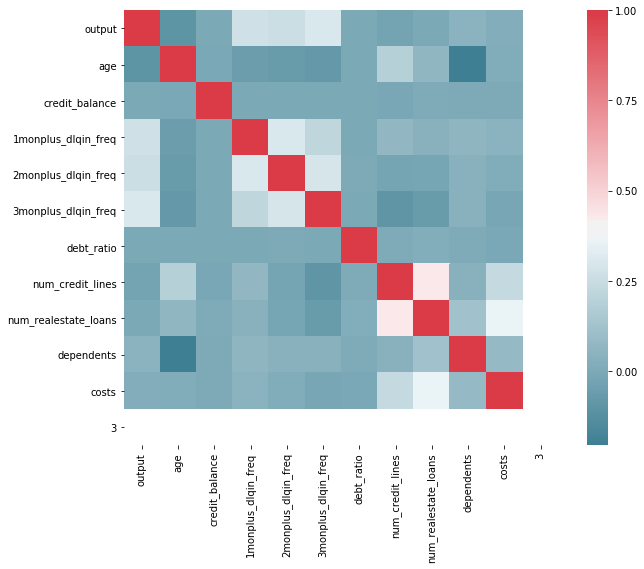

In [132]:
plt.show()

There is a linear relationship between these time span variables as confirmed here but it looks like we have outliers 

In [12]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def plot(x):
    fig, axes = plt.subplots(nrows=2)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

In [60]:
df['costs']=df['debt_ratio']*df['income']


In [97]:
med=df['1monplus_dlqin_freq'].median()
med

0.0

In [120]:
df.loc[df['1monplus_dlqin_freq']>50,'1monplus_dlqin_freq']=med
df.loc[df['2monplus_dlqin_freq']>50,'2monplus_dlqin_freq']=med
df.loc[df['3monplus_dlqin_freq']>50,'3monplus_dlqin_freq']=med

In [142]:
df = df.drop('income', axis=1)

In [143]:
sum(df['1monplus_dlqin_freq']>50)

0

In [125]:
#df=df.take(np.random.permutation(len(df))[:20000])
X_sample=df.iloc[:, 1:].values
#plot(X_sample[:,2])
#plt.show()

In [135]:
predictors=df.iloc[:, 1:]

In [14]:
percentile_based_outlier(X_sample[:,2])

array([False, False, False, ..., False, False, False], dtype=bool)

In [62]:
y = df.iloc[:, 0].values
y

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [141]:
df.columns

Index([              'output',                  'age',       'credit_balance',
        '1monplus_dlqin_freq',  '2monplus_dlqin_freq',  '3monplus_dlqin_freq',
                 'debt_ratio',     'num_credit_lines', 'num_realestate_loans',
                 'dependents',                'costs',                      3],
      dtype='object')

In [126]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y, test_size = 0.25, random_state = 0)

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [127]:
y_pred = classifier.predict(X_test)

C:\Users\raunak\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


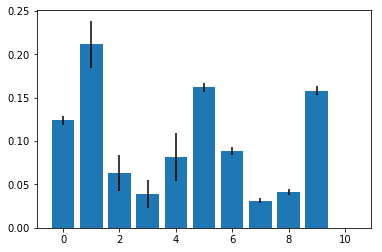

In [137]:
importance = classifier.feature_importances_
importance = pd.DataFrame(importance, index=predictors.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in classifier.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [138]:
predictors.head()

,age,credit_balance,1monplus_dlqin_freq,2monplus_dlqin_freq,3monplus_dlqin_freq,debt_ratio,num_credit_lines,num_realestate_loans,dependents,costs,3
0,45,0.766127,2.0,0.0,0.0,0.802982,13,6,2.0,7323.197016,0.0
1,40,0.957151,0.0,0.0,0.0,0.121876,4,0,1.0,316.878123,0.0
2,38,0.658180,1.0,0.0,1.0,0.085113,2,0,0.0,258.914887,0.0
3,30,0.233810,0.0,0.0,0.0,0.036050,5,0,0.0,118.963951,0.0
4,49,0.907239,1.0,0.0,0.0,0.024926,7,1,0.0,1584.975094,0.0


credit bal, debt_ratio and costs are the most important variables

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [128]:
cm

array([[27664,   294],
       [ 1748,   362]], dtype=int64)

In [129]:
(cm[0][0]+cm[0][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])

0.9298257283490754

In [130]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.57767602656523709

RF with 500 trees gives a poor performance. Lets now try another ensemble model adaboost.

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

In [24]:
y_pred=bdt.predict(X_test)

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[27650,   308],
       [ 1717,   393]], dtype=int64)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

Lets see how a single linear model SVC performs

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr, tpr)